## Box Filter

A _box filter_ is replacing every pixel in an image with the mean of the neighborhood values around it.

On a coding level, it can be implemented with regular nested for loops or with vectorization. This small tutorial demonstrates the benefits of using vectorization.

First, let's write some code to load and display a test image:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import urllib.request 
import timeit

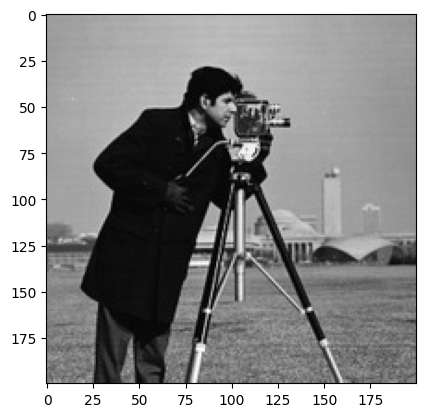

In [4]:
# Load the cameraman image
url = 'https://dome.mit.edu/bitstream/handle/1721.3/195767/cameraman.tif.jpg?sequence=4&isAllowed=y' 

with urllib.request.urlopen(url) as resp: 
    img = np.asarray(bytearray(resp.read()), dtype="uint8") 
    img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE) 


def show(img):
    if type(img)==list:
        img = np.concatenate(img, axis=1)
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))


show(img)

### Naive loop code

For a filter size of $f \times f$ pixels and an image size of $n \times n$ pixels, the complexity of the naive loop version is $\mathcal{O}(f^2 \cdot n^2)$.

Here is how the naive for-loop code could look like:

In [5]:
def box_filter_loop(img, box_width, box_height):
    box_size = box_width * box_height
    result = np.zeros([img.shape[0] - (box_height - 1), img.shape[1] - (box_width - 1)])

    # Iterate over the image
    for result_y in range(result.shape[0]):
        for result_x in range(result.shape[1]):
            local_sum = 0

            # Sum up the image pixels covered by the box filter
            for filter_y in range(result_y, result_y + box_height):
                for filter_x in range(result_x, result_x + box_width):
                    local_sum += img[filter_y, filter_x]

            result[result_y, result_x] = local_sum / box_size
    return result
            

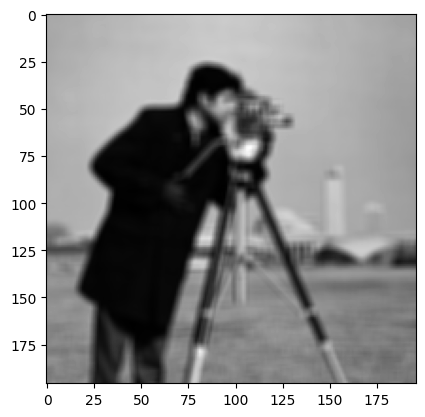

In [6]:
# Check the result of the box filter
result_loop = box_filter_loop(img, 5,5)
show(result_loop)

### Developing the vectorized solution

A vectorized solution replaces multiple individual mathematical computations (e.g., adding up several numbers pairwise) by a computation on vectors (e.g., adding up all elements in a vector).
Not only are the libraries offering these vector computations (e.g., numpy) often highly optimized towards performance, but modern CPUs and GPUs support SIMD (Single Instruction, Multiple Data) instructions that allow the same operation on multiple data elements at the same time.
Hence, a vectorized solution is usually a lot faster.

The vectorization solution can be derived from the naive solution by first reordering some lines of code.

#### Step 1

Make the image iteration the new inner loops:
```python
# Iterate over the box filter
for filter_y in range(box_height):
    for filter_x in range(box_width):

        # Iterate over the image
        for result_y in range(result.shape[0]):
            for result_x in range(result.shape[1]):

                # Sum up the values covered by the filter in the result image
                result[result_y, result_x] += img[result_y + filter_y, result_x + filter_x] 

final_result = result / box_size
```

#### Step 2

Replace the image iteration with Python's list slicing:
```python
# Iterate over the box filter
for filter_y in range(box_height):
    for filter_x in range(box_width):

        # Sum up the values covered by the filter in the result image
        result += img[filter_y:filter_y+result.shape[0], 
                        filter_x:filter_x+result.shape[1]]

final_result = result / box_size
```

### Vectorized Solution

Then, put everything together as a function:

In [7]:
def box_filter_vectorized(img, box_width, box_height):
    box_size = box_width * box_height
    result = np.zeros([img.shape[0] - (box_height - 1), img.shape[1] - (box_width - 1)])

    # Iterate over the box filter
    for filter_y in range(box_height):
        for filter_x in range(box_width):

            # Sum up the values covered by the filter in the result image
            result += img[filter_y:filter_y+result.shape[0], 
                            filter_x:filter_x+result.shape[1]]

    final_result = result / box_size
    return final_result

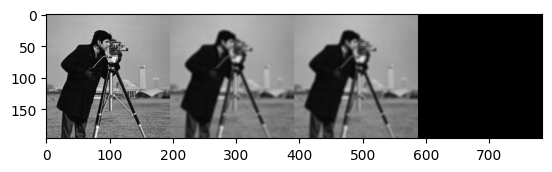

In [8]:
# Compare the two implementations (original, naive, vectorized, difference)
naive = box_filter_loop(img, 5,5)
vectorized = box_filter_vectorized(img, 5, 5)
show([img[2:-2,2:-2], naive, vectorized, (naive - vectorized)**2])

### Evaluation

As you can see from the above results, both algorithms produce the same image.
Now, let's compare their runtime.

While the runtime of the naive loop version increases exponentially by the _filter size_, the vectorized solution produces results nearly instantly.

In [9]:
timeit_ctx =  'from __main__ import ' + ', '.join(globals())
loop_filter_speeds = {}
vectorized_speeds = {}
filter_sizes = [3, 5, 7, 9, 11, 13, 15]

for filter_size in filter_sizes:
    loop_filter_speeds[filter_size] = timeit.Timer(lambda: box_filter_loop(img, filter_size, filter_size)).timeit(number=1)
    vectorized_speeds[filter_size] = timeit.Timer(lambda: box_filter_vectorized(img, filter_size, filter_size)).timeit(number=1)

Text(0.5, 1.0, 'Box-filter Speedup by filter size')

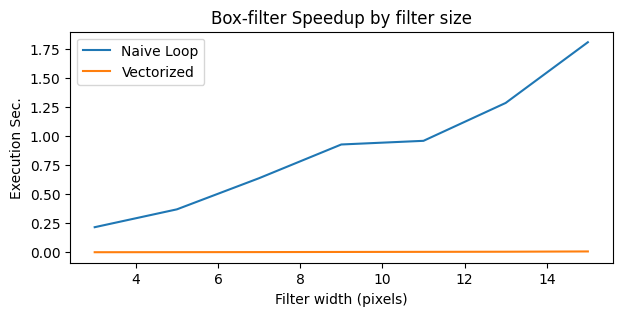

In [10]:
plt.figure(figsize=(7, 3))
plt.plot(filter_sizes, [[loop_filter_speeds[sz], vectorized_speeds[sz]] for sz in filter_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Filter width (pixels)")
plt.legend(["Naive Loop", "Vectorized"])
plt.title("Box-filter Speedup by filter size")

Additionally, the vectorized performance improves almost exponentially by _image size_ as well!

In [11]:
loop_speeds = {}
vectorized_speeds = {}
image_sizes = [64, 128, 256, 512, 1024]
filter_size = 3

for img_size in image_sizes:
    rnd_img = np.random.rand(img_size, img_size)
    loop_speeds[img_size] = timeit.Timer(lambda: box_filter_loop(rnd_img, filter_size, filter_size)).timeit(number=1)
    vectorized_speeds[img_size] = timeit.Timer(lambda: box_filter_vectorized(rnd_img, filter_size, filter_size)).timeit(number=1)

Text(0.5, 1.0, 'Box-filter Speedup by image size')

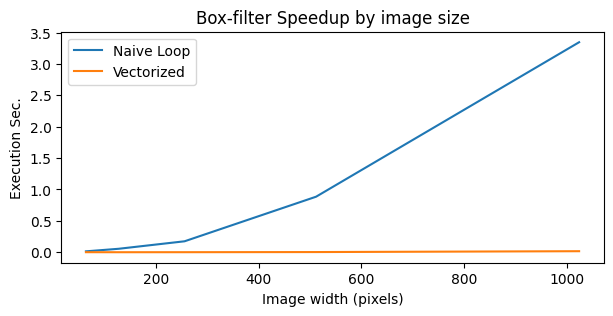

In [12]:
plt.figure(figsize=(7, 3))
plt.plot(image_sizes,[[loop_speeds[sz], vectorized_speeds[sz]] for sz in image_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Image width (pixels)")
plt.legend(["Naive Loop", "Vectorized"])
plt.title("Box-filter Speedup by image size")

### Conclusion

The vectorization solution is a lot faster. However, did we reduce the problem's complexity with vectorization? Not really!

### Can we do even better?

Yes, we can use integral images! An integral image is an image, where every pixel contains the sum of all original pixels above and to the left, inclusive.

Using numpy's `cumsum` function, we can easily create such an integral image:

In [13]:
image = np.array([[1,2,3], [4,5,6], [7, 8, 9]])
integral_image = image.cumsum(axis=0).cumsum(axis=1)

print('Original Image')
print(image)
print('Integral Image')
print(integral_image)

Original Image
[[1 2 3]
 [4 5 6]
 [7 8 9]]
Integral Image
[[ 1  3  6]
 [ 5 12 21]
 [12 27 45]]


We can get the sum of the pixels in any rectangular region by reading only the corners of the rectangular region in the integral image.
For example, if we need the pixel sum of the rectangle with top left corner $(y_1, x_1)$ (excluded) and bottom right corner $(y_2, x_2)$ (included):

In [14]:
# Rectangle coordinates for values 5, 6, 8, 9 (top left coordinate excluded, bottom right included)
y1 = 0
x1 = 0
y2 = 2
x2 = 2

sum_1 = image[y1+1:y2+1, x1+1:x2+1].sum()
sum_2 = integral_image[y1, x1] + integral_image[y2, x2] - integral_image[y2, x1] - integral_image[y1, x2]

print('Sum of rectangle, manually computed:', sum_1)
print('Sum of rectangle, computed with integral image:', sum_2)

Sum of rectangle, manually computed: 28
Sum of rectangle, computed with integral image: 28


Using an integral image, the complexity of a box filter implementation is reduced from $\mathcal{O}(f^2 \cdot n^2)$ to only $\mathcal{O}(n^2)$.

In [15]:
def box_filter_integral(img, box_width, box_height):
    box_size = box_width * box_height

    integral_image = img.cumsum(axis=0).cumsum(axis=1)

    # Pad the integral image with zeros to guarantee that the box filter works at the borders
    integral_image = np.pad(integral_image, ((1, 0), (1, 0)), mode='constant', constant_values=0)

    width, height = integral_image.shape
    top_left = integral_image[0:height-box_height, 0:width-box_width]
    bottom_right = integral_image[box_height:height, box_width:width]
    top_right = integral_image[0:height-box_height, box_width:width]
    bottom_left = integral_image[box_height:height, 0:width-box_width]
    result = (top_left + bottom_right - top_right - bottom_left) / box_size
    return result 

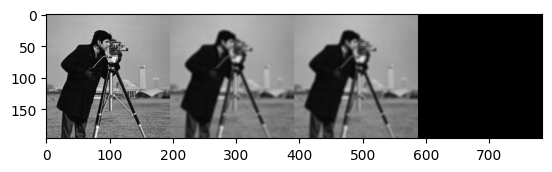

In [16]:
# Compare the two implementations (original, vectorized, integral, difference)
vectorized = box_filter_vectorized(img, 5, 5)
integral = box_filter_integral(img, 5, 5)
show([img[2:-2,2:-2], vectorized, integral, (vectorized - integral)**2])

Let's compare the runtime of the vectorized solution and the integral image solution.
While the runtime of the vectorized version increases exponentially by the _filter size_, the integral image solution produces results nearly instantly.

In [17]:
integral_speeds = {}
vectorized_speeds = {}
filter_sizes = [3, 5, 7, 9, 11, 13, 15, 31, 61]
rnd_img = np.random.rand(1024, 1024)

for filter_size in filter_sizes:
    integral_speeds[filter_size]=timeit.Timer(lambda: box_filter_integral(rnd_img, filter_size,filter_size)).timeit(number=1)
    vectorized_speeds[filter_size]=timeit.Timer(lambda: box_filter_vectorized(rnd_img, filter_size,filter_size)).timeit(number=1)

Text(0.5, 1.0, 'Box-filter Speedup by filter size')

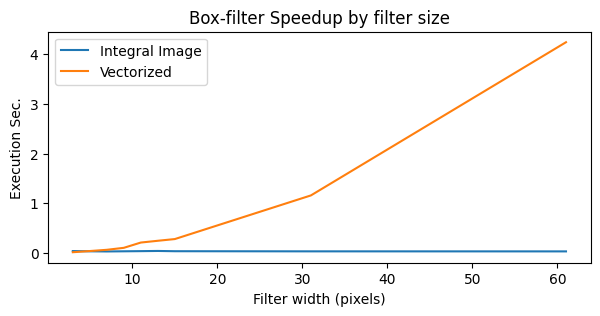

In [18]:
plt.figure(figsize=(7, 3))
plt.plot(filter_sizes, [[integral_speeds[sz], vectorized_speeds[sz]] for sz in filter_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Filter width (pixels)")
plt.legend(["Integral Image", "Vectorized"])
plt.title("Box-filter Speedup by filter size")

### Overall conclusion

Improving code by leveraging vectorization is great! However, reducing the problem's complexity is even better!

For the full picture, compare the runtime of all three versions below.

Text(0.5, 1.0, 'Box-filter Speedup by filter size')

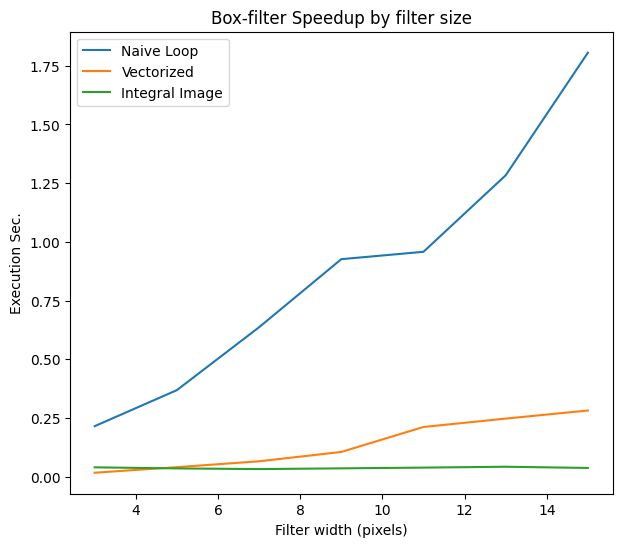

In [19]:
filter_sizes = [3, 5, 7, 9, 11, 13, 15]
plt.figure(figsize=(7, 6))
plt.plot(filter_sizes, [[loop_filter_speeds[sz], vectorized_speeds[sz], integral_speeds[sz]] for sz in filter_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Filter width (pixels)")
plt.legend(["Naive Loop", "Vectorized", "Integral Image"])
plt.title("Box-filter Speedup by filter size")